# Palm Weevil Trap Detection - Model Evaluation

This notebook evaluates deep learning models trained to classify between Red Palm Weevil (RPW) traps and Non-RPW traps from images. We'll evaluate two models:
1. MobileNetV3 Large
2. EfficientNet B0

## Overview
- Load pre-trained models
- Process test images with the same transformations used during training
- Evaluate model performance on test data
- Compare results between models

## Imports and Device Setup

In [1]:
import os
import glob
from PIL import Image
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import (
    mobilenet_v3_large,
    MobileNet_V3_Large_Weights,
    efficientnet_b0,
    EfficientNet_B0_Weights,
    efficientnet_b4,
    EfficientNet_B4_Weights,
)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)
import matplotlib.pyplot as plt
import seaborn as sns

# Device setup - use GPU if available
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print("Using device:", device)

Using device: mps


In [2]:
seed = 42
# Set seed for reproducibility
torch.manual_seed(seed)

In [ ]:
MODEL_CONFIGS = {
    "mobilenet": {
        "builder": mobilenet_v3_large,
        "weights": MobileNet_V3_Large_Weights.DEFAULT,
        "classifier_index": 3,
        "input_size": 224,
    },
    "efficientnet_b0": {
        "builder": efficientnet_b0,
        "weights": EfficientNet_B0_Weights.DEFAULT,
        "classifier_index": 1,
        "input_size": 224,
    },
    "efficientnet_b4": {
        "builder": efficientnet_b4,
        "weights": EfficientNet_B4_Weights.DEFAULT,
        "classifier_index": 1,
        "input_size": 380,
    },
}

## Model Loading Function

This function loads our trained models from saved checkpoints. We're using two different architectures:
1. MobileNetV3 Large - a lightweight model designed for mobile devices
2. EfficientNet B0 - known for balancing accuracy and computational efficiency

For both models, we've customized the classifier head to work with our binary classification task (RPW-trap vs NRPW-trap).

In [4]:
def load_model(model_name, path, num_classes=2):
    if model_name not in MODEL_CONFIGS:
        raise ValueError(f"Unsupported model name: {model_name}")

    config = MODEL_CONFIGS[model_name]
    model = config["builder"](
        weights=None
    )  # Initialize the model without pre-trained weights

    # Access the correct layer's in_features depending on the model
    in_features = model.classifier[config["classifier_index"]].in_features
    model.classifier = nn.Sequential(
        nn.Linear(in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes),
    )

    # Load the trained weights from the path
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()  # Set the model to evaluation mode
    return model.to(device)  # Move the model to the correct device

## Image Preprocessing

We apply the same transformations that were used during model training:
1. Resize images based on the model
2. Convert to PyTorch tensors
3. Normalize using ImageNet mean and standard deviation values

In [5]:
def get_transform(model_name):
    if model_name not in MODEL_CONFIGS:
        raise ValueError(f"Unsupported model name: {model_name}")

    model_config = MODEL_CONFIGS[model_name]
    img_size = model_config["input_size"]

    transform = transforms.Compose(
        [
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    return transform

## Data Loading Function

This function loads test images from their respective class folders and processes them using our transformation pipeline.

In [6]:
def load_raw_trap_images(folder_path, class_map):
    images, labels = [], []

    for class_name, label in class_map.items():
        class_folder = os.path.join(folder_path, class_name)
        img_paths = glob.glob(os.path.join(class_folder, "*.*"))
        if not img_paths:
            print(f"⚠️ Skipping {class_name} — no images found.")
            continue

        print(f"Found {len(img_paths)} images in class {class_name}")
        for img_path in img_paths:
            try:
                img = Image.open(img_path).convert("RGB")  # No transform here
                images.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    if not images:
        return None, None

    # Change this line to return raw images and labels (no transformation here)
    return images, torch.tensor(labels)

## Model Evaluation Function

This function evaluates model performance using:
1. Accuracy metric
2. Confusion matrix visualization

The confusion matrix helps us understand false positives and false negatives in our classification task.

In [7]:
def evaluate(model, test_loader, class_names=None, show_cm=True):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device, non_blocking=(device.type == "cuda"))
            labels = labels.to(device, non_blocking=(device.type == "cuda"))

            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    # Infer class names if not provided
    if (
        class_names is None
        and hasattr(test_loader.dataset, "dataset")
        and hasattr(test_loader.dataset.dataset, "classes")
    ):
        class_names = test_loader.dataset.dataset.classes

    # Metrics
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, zero_division=0)
    rec = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

    print(f"\nEvaluation Metrics:")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")

    print("\nClassification Report:")
    print(
        classification_report(
            all_labels, all_preds, target_names=class_names, zero_division=0
        )
    )

    # Confusion matrix
    if show_cm:
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(6, 5))
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names,
        )
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.tight_layout()
        plt.show()

    return acc, prec, rec, f1

## Main Evaluation

Now we'll load the test data and evaluate both models.

In [11]:
# Class definitions
class_names = ["NRPW-trap", "RPW"]
class_to_idx = {name: idx for idx, name in enumerate(class_names)}

# Load test data
test_root = "./test"
print(f"Loading test images from {test_root}...")
raw_images, raw_labels = load_raw_trap_images(test_root, class_to_idx)

if raw_images is None or len(raw_images) == 0:
    print("No images to evaluate. Please check your test data directory.")
else:
    print(f"Loaded {len(raw_images)} test images in total.")

Loading test images from ./test...
⚠️ Skipping NRPW-trap — no images found.
Found 793 images in class RPW
Loaded 793 test images in total.


In [9]:
from torch.utils.data import Dataset, DataLoader
# Custom Dataset class
class TrapImagesDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label


# Apply transformation and create DataLoader
def create_dataloader(images, labels, model_name, batch_size=32):
    transform = get_transform(model_name)
    dataset = TrapImagesDataset(images, labels, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

### MobileNetV3 Evaluation

MobileNetV3 is designed to be computationally efficient while maintaining good accuracy. Let's evaluate its performance on our test set.


🔍 Loading MobileNetV3 model...
MobileNetV3 model loaded successfully.

Evaluation Metrics:
Accuracy : 0.8134
Precision: 1.0000
Recall   : 0.8134
F1 Score : 0.8971

Classification Report:
              precision    recall  f1-score   support

   NRPW-trap       0.00      0.00      0.00         0
         RPW       1.00      0.81      0.90       793

    accuracy                           0.81       793
   macro avg       0.50      0.41      0.45       793
weighted avg       1.00      0.81      0.90       793



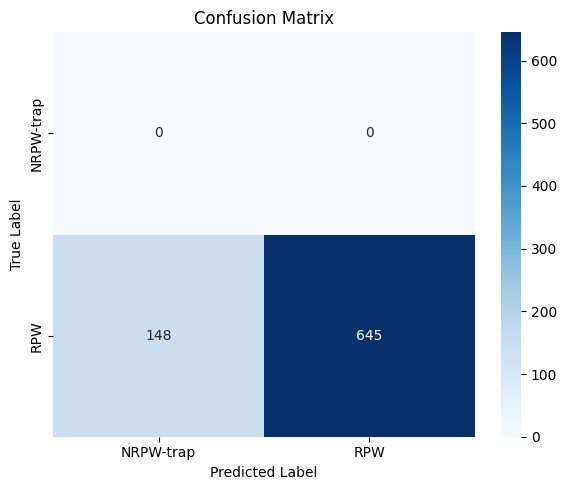

In [12]:
try:
    # Load the model (MobileNetV3)
    print("\n🔍 Loading MobileNetV3 model...")
    mobilenet = load_model("mobilenet", "saved_models_states/mobilenetv3_rpw.pth")
    print("MobileNetV3 model loaded successfully.")

    # Apply transformation and create DataLoader
    test_loader = create_dataloader(raw_images, raw_labels, "mobilenet", batch_size=32)

    # Now, pass the DataLoader to the evaluation function
    mobile_metrics = evaluate(mobilenet, test_loader, class_names)
except Exception as e:
    print(f"Error evaluating MobileNetV3: {e}")

### EfficientNetB0 Evaluation

EfficientNetB0 is known for its scaling method that uniformly scales network width, depth, and resolution. Let's evaluate EfficientNet B0 on our test set.


🔍 Loading EfficientNetB0 model...
EfficientNetB0 model loaded successfully.

Evaluation Metrics:
Accuracy : 0.9092
Precision: 1.0000
Recall   : 0.9092
F1 Score : 0.9524

Classification Report:
              precision    recall  f1-score   support

   NRPW-trap       0.00      0.00      0.00         0
         RPW       1.00      0.91      0.95       793

    accuracy                           0.91       793
   macro avg       0.50      0.45      0.48       793
weighted avg       1.00      0.91      0.95       793



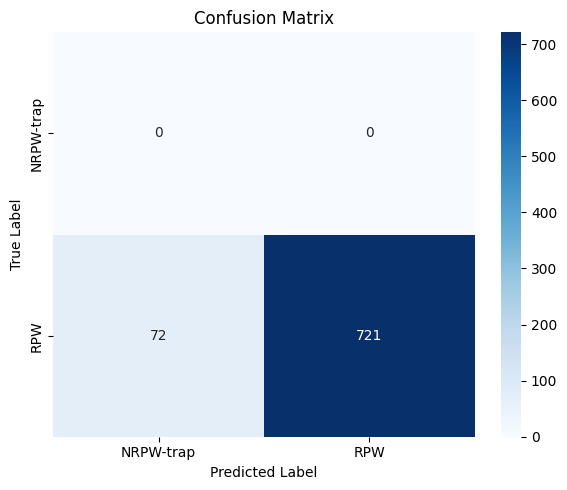

In [13]:
try:
    # Load the model (EfficientNetB0)
    print("\n🔍 Loading EfficientNetB0 model...")
    efficientnet = load_model(
        "efficientnet_b0", "saved_models_states/efficientnet_b0_rpw.pth"
    )
    print("EfficientNetB0 model loaded successfully.")

    # Apply transformation and create DataLoader
    test_loader = create_dataloader(
        raw_images, raw_labels, "efficientnet_b0", batch_size=32
    )

    # Now, pass the DataLoader to the evaluation function
    eff0_metrics = evaluate(efficientnet, test_loader, class_names)

except Exception as e:
    print(f"Error evaluating EfficientNetB0: {e}")

### EfficientNetB4 Evaluation

EfficientNetB4 is known for its scaling method that uniformly scales network width, depth, and resolution. Let's evaluate EfficientNet B4 on our test set.


🔍 Loading EfficientNetB4 model...
EfficientNetB4 model loaded successfully.

Evaluation Metrics:
Accuracy : 0.8424
Precision: 1.0000
Recall   : 0.8424
F1 Score : 0.9144

Classification Report:
              precision    recall  f1-score   support

   NRPW-trap       0.00      0.00      0.00         0
         RPW       1.00      0.84      0.91       793

    accuracy                           0.84       793
   macro avg       0.50      0.42      0.46       793
weighted avg       1.00      0.84      0.91       793



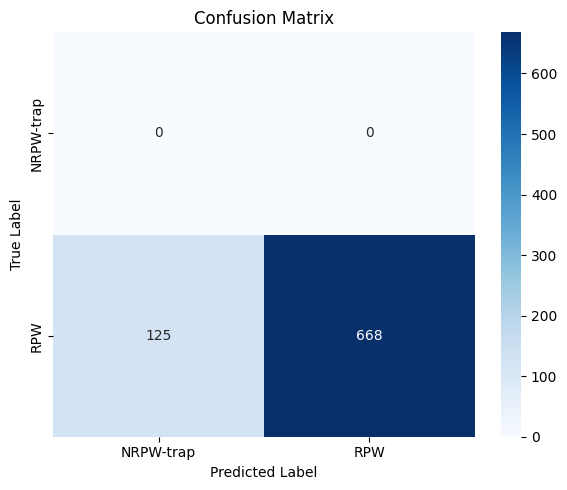

In [15]:
try:
    # Load the model (EfficientNetB0)
    print("\n🔍 Loading EfficientNetB4 model...")
    efficientnet = load_model(
        "efficientnet_b4", "saved_models_states/efficientnet_b4_rpw.pth"
    )
    print("EfficientNetB4 model loaded successfully.")

    # Apply transformation and create DataLoader
    test_loader = create_dataloader(
        raw_images, raw_labels, "efficientnet_b4", batch_size=32
    )

    # Now, pass the DataLoader to the evaluation function§
    eff4_metrics = evaluate(efficientnet, test_loader, class_names)

except Exception as e:
    print(f"Error evaluating EfficientNetB4: {e}")

### EfficientNetB6 Evaluation

EfficientNetB6 is known for its scaling method that uniformly scales network width, depth, and resolution. Let's evaluate EfficientNet B6 on our test set.

In [ ]:
try:
    # Load the model (EfficientNetB0)
    print("\n🔍 Loading EfficientNetB6 model...")
    efficientnet = load_model(
        "efficientnet_b6", "saved_models_states/efficientnet_b6_rpw.pth"
    )
    print("EfficientNetB6 model loaded successfully.")

    # Apply transformation and create DataLoader
    test_loader = create_dataloader(
        raw_images, raw_labels, "efficientnet", batch_size=32
    )

    # Now, pass the DataLoader to the evaluation function§
    eff4_metrics = evaluate(efficientnet, test_loader, class_names)

except Exception as e:
    print(f"Error evaluating EfficientNetB6: {e}")

## Model Comparison

Let's compare the performance of both models side by side.

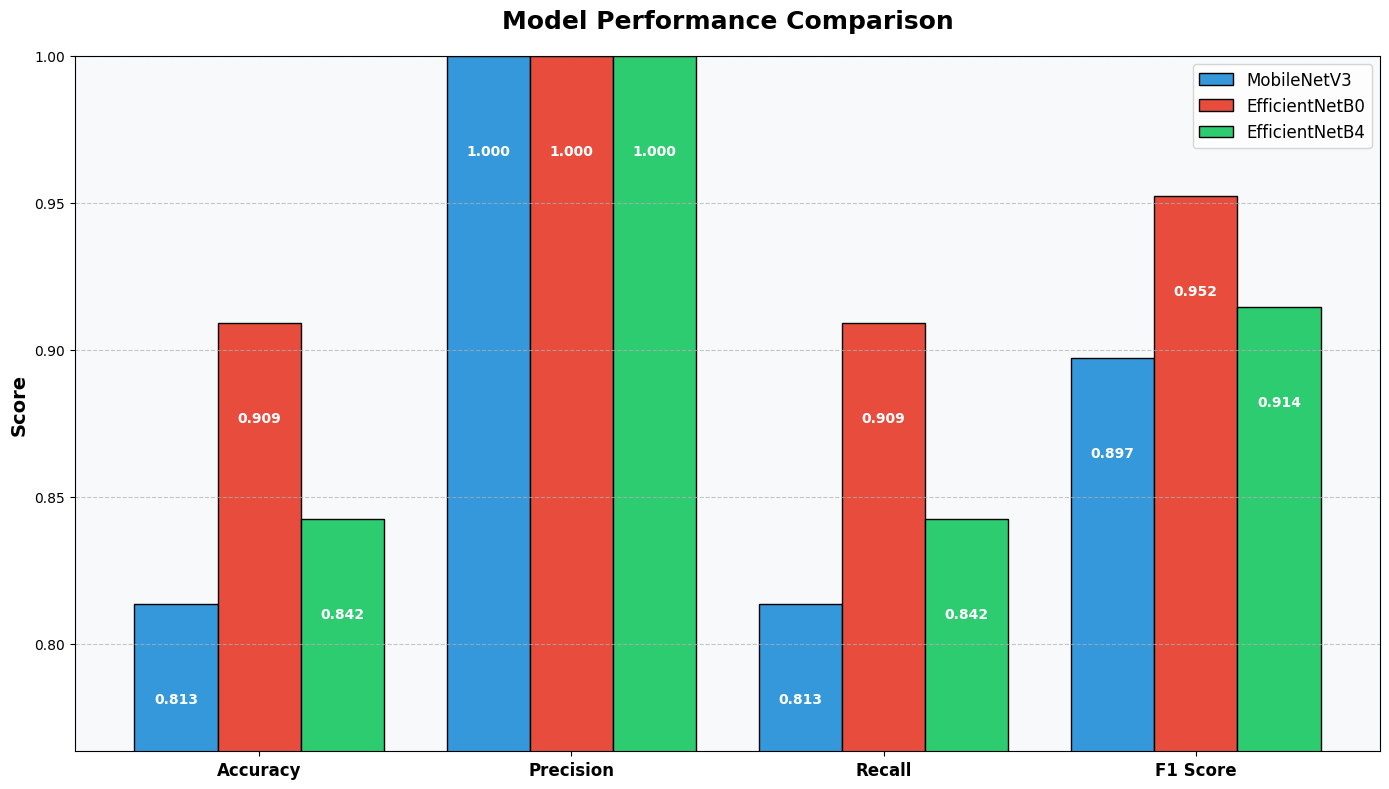

In [16]:
# Step 2: Organize metrics into a dictionary
model_metrics = {
    "MobileNetV3": list(mobile_metrics),
    "EfficientNetB0": list(eff0_metrics),
    "EfficientNetB4": list(eff4_metrics),
}


# Step 3: Define plotting function
def plot_model_comparison(model_metrics):
    import numpy as np
    import matplotlib.pyplot as plt

    metrics_names = ["Accuracy", "Precision", "Recall", "F1 Score"]
    models = list(model_metrics.keys())
    values = [model_metrics[m] for m in models]

    num_metrics = len(metrics_names)
    num_models = len(models)
    x = np.arange(num_metrics)
    width = 0.8 / num_models  # Keep bars within group

    plt.figure(figsize=(14, 8))

    # Custom color palette
    colors = ["#3498db", "#e74c3c", "#2ecc71", "#f39c12", "#9b59b6", "#1abc9c"]

    # Plot each model's bars
    for i, (model_name, scores) in enumerate(model_metrics.items()):
        offset = (i - num_models / 2) * width + width / 2
        plt.bar(
            x + offset,
            scores,
            width,
            label=model_name,
            color=colors[i % len(colors)],
            edgecolor="black",
            linewidth=1,
        )

        # Add value labels
        for j, score in enumerate(scores):
            plt.text(
                x[j] + offset,
                score - 0.03,
                f"{score:.3f}",
                ha="center",
                va="top",
                fontsize=10,
                fontweight="bold",
                color="white",
            )

    # Styling
    plt.xticks(x, metrics_names, fontsize=12, fontweight="bold")
    plt.ylabel("Score", fontsize=14, fontweight="bold")
    plt.title("Model Performance Comparison", fontsize=18, fontweight="bold", pad=20)
    plt.legend(fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.ylim(max(0, min(min(v) for v in values) - 0.05), 1.0)
    plt.gca().set_facecolor("#f8f9fa")
    plt.tight_layout()
    plt.show()


# Step 4: Plot all together
plot_model_comparison(model_metrics)

## Summary

In this notebook, we evaluated two deep learning models on a palm weevil trap classification task. The evaluation metrics include:

1. Overall accuracy
2. Confusion matrix showing true positives, true negatives, false positives, and false negatives

### Next Steps

Based on the evaluation results, you might consider:
- Using the better-performing model for deployment
- Collecting more training data if accuracy is not satisfactory
- Trying different model architectures or hyperparameters
- Implementing ensemble methods to combine predictions from both models